# import necessary libraries

In [35]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
import pandas as pd
import pickle
from PIL import Image
from sklearn.model_selection import train_test_split 
from sklearn.metrics import roc_curve, auc,confusion_matrix, classification_report,accuracy_score, precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Reading Data

In [3]:
def create_dataset(folder_path):
    my_list = []
    for category in ['NORMAL', 'PNEUMONIA']:  # Iterate over the two classes
        category_path = os.path.join(folder_path, category)
        for file_name in os.listdir(category_path):
            file_path = os.path.join(category_path, file_name)
            # Ensure we're only adding image files
            if os.path.isfile(file_path) and file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                my_list.append([file_path, category])
    return pd.DataFrame(my_list, columns=['file_path', 'label'])



In [4]:
# Dataset paths
dataset_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray'
train_dir = os.path.join(dataset_dir, 'train')
val_dir = os.path.join(dataset_dir, 'val')
test_dir = os.path.join(dataset_dir, 'test')

In [5]:
# Create DataFrames for train, validation, and test datasets
train_df = create_dataset(train_dir)
val_df = create_dataset(val_dir)
test_df = create_dataset(test_dir)

In [6]:
# Convert labels to numeric: NORMAL -> 0, PNEUMONIA -> 1
train_df['label'] = train_df['label'].map({'NORMAL': 0, 'PNEUMONIA': 1})
val_df['label'] = val_df['label'].map({'NORMAL': 0, 'PNEUMONIA': 1})
test_df['label'] = test_df['label'].map({'NORMAL': 0, 'PNEUMONIA': 1})

In [7]:
# Print dataset sizes
print(f"Train set size: {len(train_df)}, Validation set size: {len(val_df)}, Test set size: {len(test_df)}")

Train set size: 5216, Validation set size: 16, Test set size: 624


In [8]:
train_df.sample(5)

,file_path,label
1040,/kaggle/input/chest-xray-pneumonia/chest_xray/...,0
2193,/kaggle/input/chest-xray-pneumonia/chest_xray/...,1
2076,/kaggle/input/chest-xray-pneumonia/chest_xray/...,1
2130,/kaggle/input/chest-xray-pneumonia/chest_xray/...,1
1336,/kaggle/input/chest-xray-pneumonia/chest_xray/...,0


In [9]:
val_df.sample(5)

,file_path,label
5,/kaggle/input/chest-xray-pneumonia/chest_xray/...,0
8,/kaggle/input/chest-xray-pneumonia/chest_xray/...,1
4,/kaggle/input/chest-xray-pneumonia/chest_xray/...,0
10,/kaggle/input/chest-xray-pneumonia/chest_xray/...,1
7,/kaggle/input/chest-xray-pneumonia/chest_xray/...,0


In [10]:
test_df.sample(5)

,file_path,label
445,/kaggle/input/chest-xray-pneumonia/chest_xray/...,1
132,/kaggle/input/chest-xray-pneumonia/chest_xray/...,0
580,/kaggle/input/chest-xray-pneumonia/chest_xray/...,1
60,/kaggle/input/chest-xray-pneumonia/chest_xray/...,0
620,/kaggle/input/chest-xray-pneumonia/chest_xray/...,1


In [11]:
train_df['label'].value_counts()

label
1    3875
0    1341
Name: count, dtype: int64

In [12]:
test_df['label'].value_counts()

label
1    390
0    234
Name: count, dtype: int64

In [13]:
val_df['label'].value_counts()

label
0    8
1    8
Name: count, dtype: int64

#### validation data is too small

# Visualization 

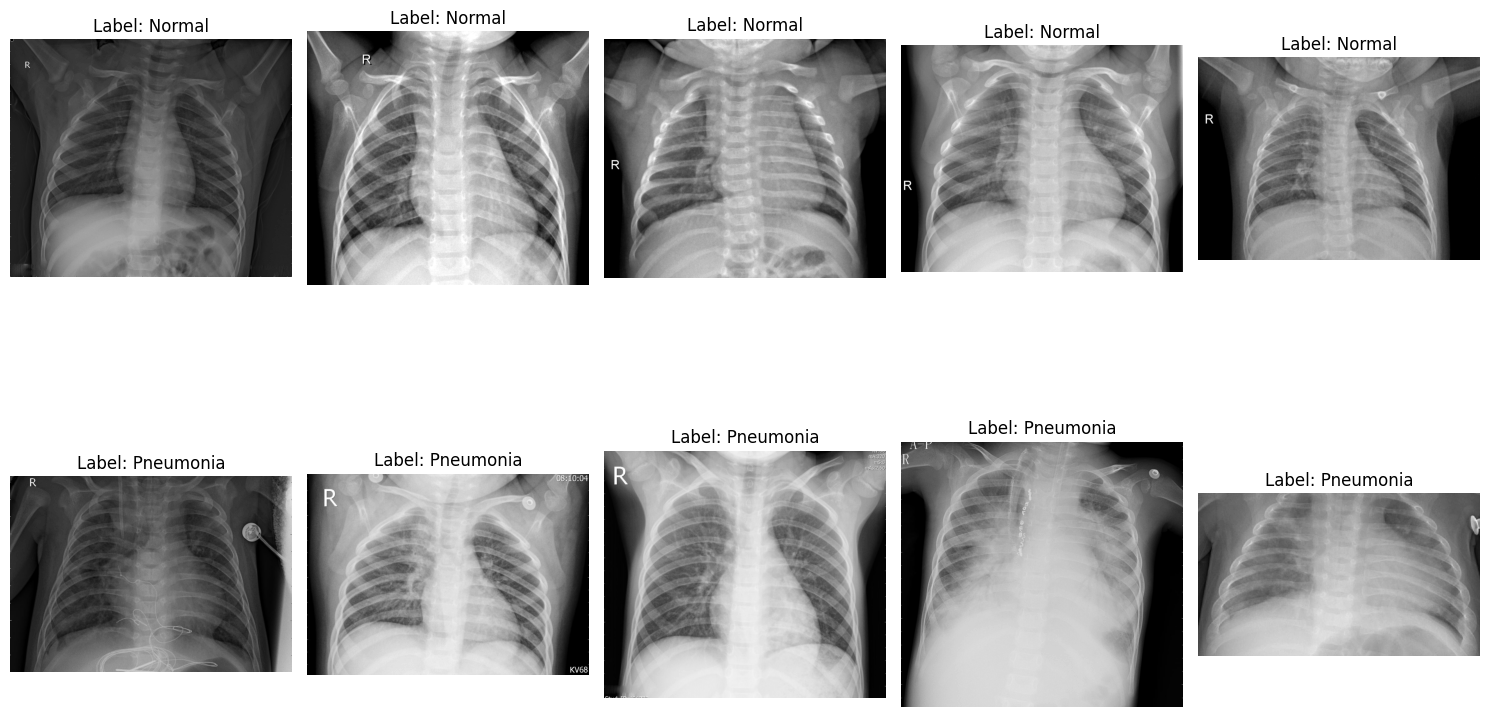

In [14]:
# Visualizing some samples from the dataset
def visualize_samples(df, n_samples=5):
    fig, axes = plt.subplots(2, n_samples, figsize=(15, 10))
    
    normal_samples = df[df['label'] == 0].iloc[:n_samples]
    pneumonia_samples = df[df['label'] == 1].iloc[:n_samples]
    # Visualize 5 NORMAL samples
    for i in range(n_samples):
        img_path = normal_samples.iloc[i, 0]
        label = normal_samples.iloc[i, 1]
        image = Image.open(img_path).convert('L')  # Open in grayscale (original format)
        axes[0, i].imshow(image, cmap='gray')
        axes[0, i].set_title(f"Label: {['Normal', 'Pneumonia'][label]}")
        axes[0, i].axis('off')
        
    # Visualize 5 PNEUMONIA samples
    for i in range(n_samples):
        img_path = pneumonia_samples.iloc[i, 0]
        label = pneumonia_samples.iloc[i, 1]
        image = Image.open(img_path).convert('L')  # Open in grayscale (original format)
        axes[1, i].imshow(image, cmap='gray')
        axes[1, i].set_title(f"Label: {['Normal', 'Pneumonia'][label]}")
        axes[1, i].axis('off')
        
    plt.tight_layout()  # Adjust the layout to minimize white space
    plt.show()

# Show 10 samples from the training data
visualize_samples(train_df)


# solve imbalance in training dataset

In [15]:
# The validation set is too small so we add this to the train data then solve the imbalanced data and split it to train and validation
df = pd.concat([train_df, val_df], ignore_index=True)

In [16]:
df.shape

(5232, 2)

In [17]:
df = pd.concat([df, test_df], ignore_index=True)

In [18]:
df.shape

(5856, 2)

In [19]:
df['label'].value_counts()

label
1    4273
0    1583
Name: count, dtype: int64

In [20]:
# Select 1,500 instances of 1
df_1 = df[df['label'] == 1].sample(n=1600, random_state=42)

# Select 1583 instances of 0
df_0 = df[df['label'] == 0]

# Concatenate the two DataFrames
df = pd.concat([df_1, df_0], ignore_index=True)

# Shuffle the new DataFrame
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [21]:
df.head(10)

,file_path,label
0,/kaggle/input/chest-xray-pneumonia/chest_xray/...,0
1,/kaggle/input/chest-xray-pneumonia/chest_xray/...,1
2,/kaggle/input/chest-xray-pneumonia/chest_xray/...,1
3,/kaggle/input/chest-xray-pneumonia/chest_xray/...,1
4,/kaggle/input/chest-xray-pneumonia/chest_xray/...,0
5,/kaggle/input/chest-xray-pneumonia/chest_xray/...,1
6,/kaggle/input/chest-xray-pneumonia/chest_xray/...,1
7,/kaggle/input/chest-xray-pneumonia/chest_xray/...,1
8,/kaggle/input/chest-xray-pneumonia/chest_xray/...,1
9,/kaggle/input/chest-xray-pneumonia/chest_xray/...,0


In [22]:
df['label'].value_counts()

label
1    1600
0    1583
Name: count, dtype: int64

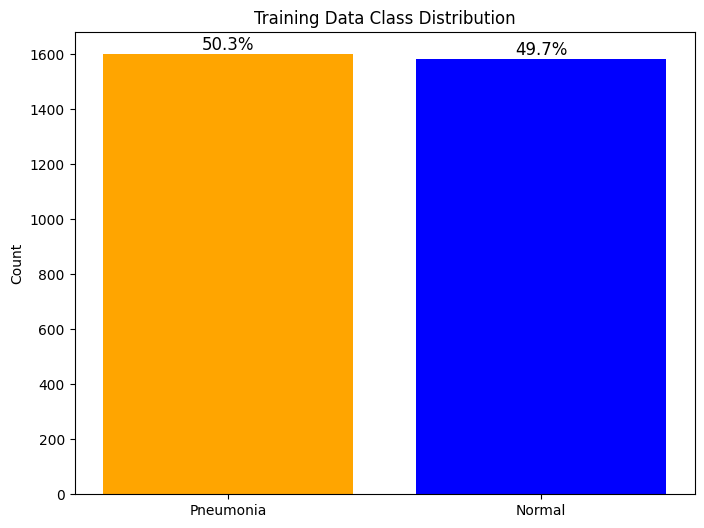

In [23]:
# Show the target
df_counts = df['label'].value_counts()

plt.figure(figsize=(8, 6))
bars = plt.bar(['Pneumonia', 'Normal'], df_counts, color=['orange', 'blue'])

# Add percentages on top of each bar
total = df_counts.sum()
for bar, count in zip(bars, df_counts):
    percentage = (count / total) * 100
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
             f'{percentage:.1f}%', ha='center', va='bottom', fontsize=12)

plt.title("Training Data Class Distribution")
plt.ylabel("Count")
plt.show()


### Split the data set to train , test and validation 

In [24]:
train_df, test_df = train_test_split(df, test_size=0.15, stratify=df['label'], random_state=42)

# Display the shapes of the resulting datasets
print("Training set shape:", train_df.shape)
print("test set shape:", test_df.shape)


Training set shape: (2705, 2)
test set shape: (478, 2)


In [25]:
train_df, val_df = train_test_split(train_df, test_size=0.15, stratify=train_df['label'], random_state=42)

# Display the shapes of the resulting datasets
print("Training set shape:", train_df.shape)
print("Validation set shape:", val_df.shape)


Training set shape: (2299, 2)
Validation set shape: (406, 2)


In [26]:
train_df['label'].value_counts()

label
1    1156
0    1143
Name: count, dtype: int64

In [27]:
test_df['label'].value_counts()

label
1    240
0    238
Name: count, dtype: int64

In [28]:
val_df['label'].value_counts()

label
1    204
0    202
Name: count, dtype: int64

# Data preparation

In [29]:
train_df

,file_path,label
2073,/kaggle/input/chest-xray-pneumonia/chest_xray/...,1
2291,/kaggle/input/chest-xray-pneumonia/chest_xray/...,0
2882,/kaggle/input/chest-xray-pneumonia/chest_xray/...,0
192,/kaggle/input/chest-xray-pneumonia/chest_xray/...,0
1822,/kaggle/input/chest-xray-pneumonia/chest_xray/...,1
...,...,...
2486,/kaggle/input/chest-xray-pneumonia/chest_xray/...,1
1517,/kaggle/input/chest-xray-pneumonia/chest_xray/...,1
304,/kaggle/input/chest-xray-pneumonia/chest_xray/...,0
2828,/kaggle/input/chest-xray-pneumonia/chest_xray/...,1


In [31]:
# Convert numeric labels to strings in all DataFrames
train_df['label'] = train_df['label'].astype(str)
val_df['label'] = val_df['label'].astype(str)
test_df['label'] = test_df['label'].astype(str)

In [33]:
train_datagen = ImageDataGenerator(rescale=1.0 / 255)
val_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Set up the generators for training, validation, and test data
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="file_path",        # Column with file paths
    y_col="label",           # Column with labels
    target_size=(299, 299),  # Resize the images to 299x299
    batch_size=32,
    class_mode="binary",     # For binary classification
    color_mode="rgb",        # Ensure the images are 3 channels (RGB)
    shuffle=True             # Shuffle the data during training
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col="file_path",
    y_col="label",
    target_size=(299, 299),
    batch_size=32,
    class_mode="binary",
    color_mode="rgb",
    shuffle=False            # Do not shuffle to preserve the order
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="file_path",
    y_col="label",
    target_size=(299, 299),
    batch_size=32,
    class_mode="binary",
    color_mode="rgb",
    shuffle=False            # Do not shuffle to preserve the order
)

Found 2299 validated image filenames belonging to 2 classes.
Found 406 validated image filenames belonging to 2 classes.
Found 478 validated image filenames belonging to 2 classes.


In [36]:
# Load the Xception model pre-trained on ImageNet, excluding the top layers
base_model = Xception(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Freeze all layers initially
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global average pooling
x = Dense(1024, activation='relu')(x)  # Fully connected layer
x = Dense(1, activation='sigmoid')(x)  # Output layer (assuming binary classification)

# Create the new model
model = Model(inputs=base_model.input, outputs=x)

# Compile the model with a learning rate suitable for fine-tuning
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])


# Unfreeze the last 20 layers of the model
for layer in base_model.layers[-20:]:  # Unfreeze the last 20 layers
    layer.trainable = True

# Recompile the model after unfreezing
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Continue training the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_steps=val_generator.samples // val_generator.batch_size
)

# Save the training history
with open('/kaggle/working/training_history.pkl', 'wb') as file:
    pickle.dump(history.history, file)

Epoch 1/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 47s 491ms/step - accuracy: 0.8819 - loss: 0.3293 - val_accuracy: 0.9245 - val_loss: 0.1717
Epoch 2/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9375 - loss: 0.2156 - val_accuracy: 1.0000 - val_loss: 0.1127
Epoch 3/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 33s 430ms/step - accuracy: 0.9628 - loss: 0.1048 - val_accuracy: 0.9297 - val_loss: 0.1951
Epoch 4/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 0.0309 - val_accuracy: 1.0000 - val_loss: 0.0264
Epoch 5/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 33s 434ms/step - accuracy: 0.9837 - loss: 0.0517 - val_accuracy: 0.9505 - val_loss: 0.1503
Epoch 6/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 0.0169 - val_accuracy: 1.0000 - val_loss: 0.0047
Epoch 7/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 33s 429ms/step - accuracy: 0.9841 - loss: 0.0427 - val_accuracy: 0.9609 - val_loss: 0.1367
Epoch 8/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 0.0306 - val_accuracy: 1.000

In [37]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 149, 149,  │        864 │ input_layer_1[0]… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 149, 149,  │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 149, 149,  │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 147, 147,  │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 147, 147,  │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 147, 147,  │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 147, 147,  │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 147, 147,  │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 147, 147,  │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 147, 147,  │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 147, 147,  │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 74, 74,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 74, 74,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 74, 74,    │        512 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_12 (Add)        │ (None, 74, 74,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 74, 74,    │          0 │ add_12[0][0]    

 Total params: 41,811,837 (159.50 MB)

 Trainable params: 9,425,577 (35.96 MB)

 Non-trainable params: 13,535,104 (51.63 MB)

 Optimizer params: 18,851,156 (71.91 MB)

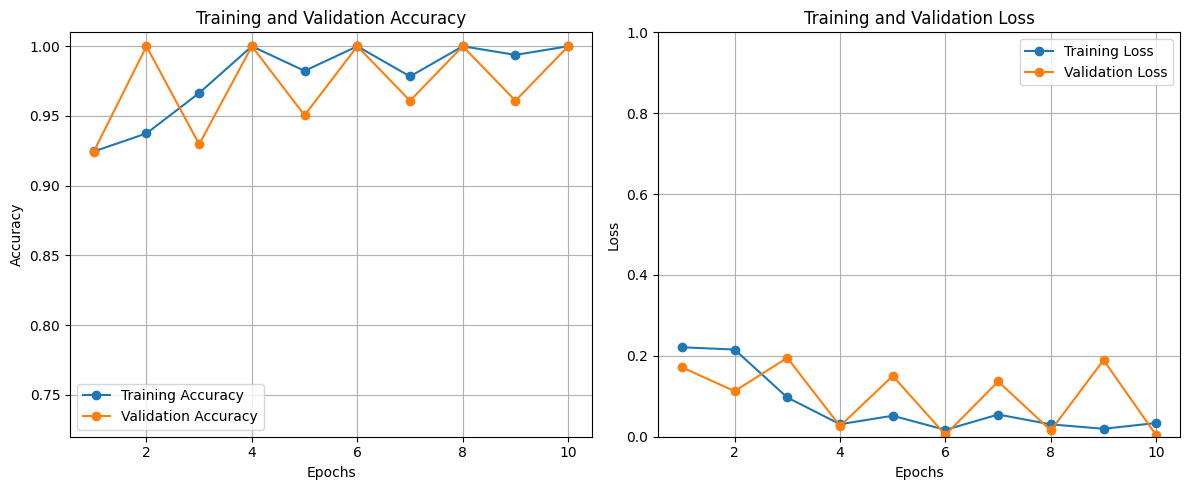

In [38]:
# Load the saved training history
with open('/kaggle/working/training_history.pkl', 'rb') as file:
    loaded_history = pickle.load(file)

# Extract accuracy and loss for training and validation
accuracy = loaded_history['accuracy']
val_accuracy = loaded_history['val_accuracy']
loss = loaded_history['loss']
val_loss = loaded_history['val_loss']
epochs = range(1, len(accuracy) + 1)

# Plot Accuracy
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, label='Training Accuracy', marker='o')
plt.plot(epochs, val_accuracy, label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.ylim(0.72, 1.01)  # Adjusted y-axis range for smoother view

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.ylim(0, 1.0)  # Adjusted y-axis range for smoother view

# Show plots
plt.tight_layout()
plt.show()

15/15 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step 


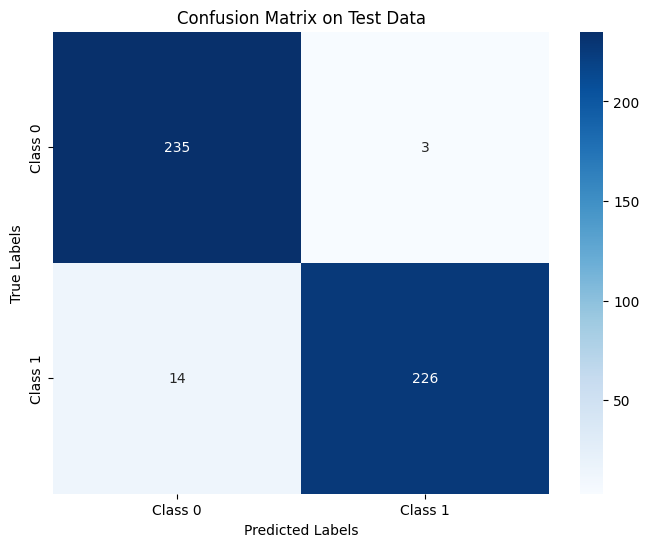

In [39]:
# Reset the test generator and predict on the entire test set
test_generator.reset()
predictions = model.predict(test_generator, steps=len(test_generator), verbose=1)

# Convert predictions to binary labels
predicted_labels = (predictions > 0.5).astype(int).flatten()

# Get the true labels (ground truth) from the test generator
true_labels = test_generator.classes

# Ensure consistency by trimming predictions if needed
min_samples = min(len(true_labels), len(predicted_labels))
true_labels = true_labels[:min_samples]
predicted_labels = predicted_labels[:min_samples]

# Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Display the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix on Test Data')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()

In [40]:
class_report = classification_report(true_labels, predicted_labels, target_names=['NORMAL', 'PNEUMONIA'], output_dict=True)

report_df = pd.DataFrame(class_report).transpose()
report_df = report_df.round(2)

print("Classification Report:")
print(tabulate(report_df, headers='keys', tablefmt='fancy_grid'))

Classification Report:
╒══════════════╤═════════════╤══════════╤════════════╤═══════════╕
│              │   precision │   recall │   f1-score │   support │
╞══════════════╪═════════════╪══════════╪════════════╪═══════════╡
│ NORMAL       │        0.94 │     0.99 │       0.97 │    238    │
├──────────────┼─────────────┼──────────┼────────────┼───────────┤
│ PNEUMONIA    │        0.99 │     0.94 │       0.96 │    240    │
├──────────────┼─────────────┼──────────┼────────────┼───────────┤
│ accuracy     │        0.96 │     0.96 │       0.96 │      0.96 │
├──────────────┼─────────────┼──────────┼────────────┼───────────┤
│ macro avg    │        0.97 │     0.96 │       0.96 │    478    │
├──────────────┼─────────────┼──────────┼────────────┼───────────┤
│ weighted avg │        0.97 │     0.96 │       0.96 │    478    │
╘══════════════╧═════════════╧══════════╧════════════╧═══════════╛


15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 377ms/step


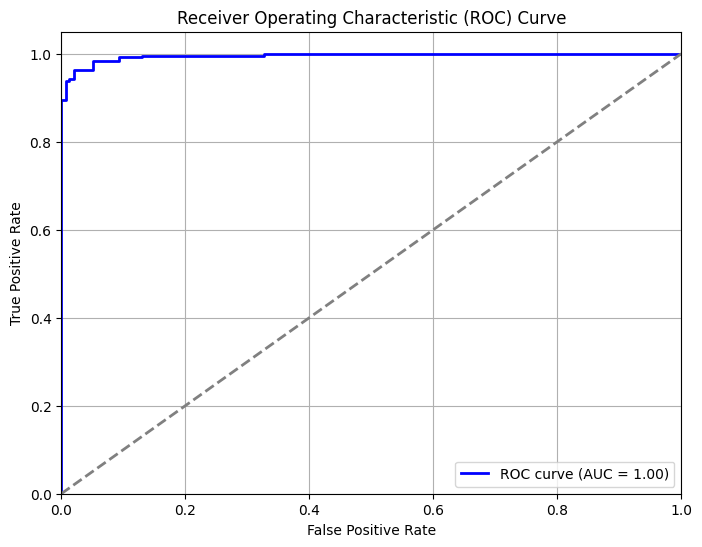

In [41]:
# Get true labels and predicted probabilities for the test set
true_labels = test_generator.classes  # Ground truth labels
predicted_probs = model.predict(test_generator)  # Model predictions (probabilities)

# Compute the ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(true_labels, predicted_probs)  # False Positive Rate, True Positive Rate
roc_auc = auc(fpr, tpr)  # Area Under the ROC Curve

# Plot the ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)  # Random guess line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()